In [158]:
import chess
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

SAMPLE_ELOS = [800, 1000, 1200, 1500, 1800, 2000, 2200]

In [159]:
df = pd.read_parquet("../data/stats_dataset.parquet")
df.tail()

,fen,next_move,games_count,global_avg_elo,global_winrate,engine_move,delta,fragility_score,variance,score,...,is_engine_top3_2200,group_count_2500,winrate_2500,score_2500,recommended_move_2500,historical_best_2500,is_best_2500,is_engine_best_2500,is_top3_2500,is_engine_top3_2500
1098,rnbqkbnr/ppp3pp/4pp2/3p4/3P1B2/4P3/PPP2PPP/RN1...,g1f3,128,1448.312500,0.554688,c2c4,-0.183348,0.159644,0.097174,-0.245818,...,<NA>,1.0,1.000000,-0.245818,g1f3,g1f3,<NA>,<NA>,<NA>,<NA>
1099,rnbqkbnr/ppp3pp/5p2/3pP3/5B2/4P3/PPP2PPP/RN1QK...,f6e5,234,1300.923077,0.388889,b8c6,-5.445125,-0.592272,0.605051,-4.247803,...,<NA>,NaN,NaN,-4.247803,f6e5,None,<NA>,<NA>,<NA>,<NA>
1100,rnbqkbnr/ppp3pp/5p2/3pp3/3P1B2/4P3/PPP2PPP/RN1...,d4e5,268,1294.925373,0.570896,d4e5,0.752079,-0.451637,-0.108881,1.094835,...,<NA>,NaN,NaN,1.094835,d4e5,None,<NA>,<NA>,<NA>,<NA>
1101,rnbqkbnr/ppp3pp/8/3pp3/5B2/4P3/PPP2PPP/RN1QKBN...,f4e5,195,1284.076923,0.574359,d1h5,-5.445125,-0.777605,-0.108940,-4.776461,...,<NA>,NaN,NaN,-4.776461,f4e5,None,<NA>,<NA>,<NA>,<NA>
1102,rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...,d7d5,145903,1523.417366,0.440176,g8f6,0.284366,-0.788823,-0.174046,0.899143,...,<NA>,2464.0,0.457386,0.899143,d7d5,d7d5,True,<NA>,True,<NA>


In [160]:
df.describe()

,games_count,global_avg_elo,global_winrate,delta,fragility_score,variance,score,group_count_500,winrate_500,score_500,...,score_1800,group_count_2000,winrate_2000,score_2000,group_count_2200,winrate_2200,score_2200,group_count_2500,winrate_2500,score_2500
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,570.000000,570.000000,1103.000000,...,1103.000000,1101.000000,1101.000000,1103.000000,1096.000000,1096.000000,1103.000000,674.000000,674.000000,1103.000000
mean,908.332729,1531.509943,0.479422,-0.121262,0.775745,0.273331,-0.623675,10.207018,0.438050,-0.623675,...,-0.623675,227.649410,0.477823,-0.623675,98.991788,0.472322,-0.623675,25.130564,0.493882,-0.623675
std,6679.778021,158.831994,0.064602,1.877036,1.225263,2.042914,2.861197,63.574867,0.375546,2.861197,...,2.861197,1674.946361,0.105605,2.861197,737.831320,0.181023,2.861197,151.258448,0.325803,2.861197
min,100.000000,1028.951389,0.172973,-24.933191,-0.825538,-0.176294,-21.652193,1.000000,0.000000,-21.652193,...,-21.652193,1.000000,0.000000,-21.652193,1.000000,0.000000,-21.652193,1.000000,0.000000,-21.652193
25%,133.000000,1414.373582,0.436695,-0.339252,-0.033885,-0.135708,-1.386648,1.000000,0.000000,-1.386648,...,-1.386648,26.000000,0.421053,-1.386648,7.000000,0.399237,-1.386648,1.000000,0.300000,-1.386648
50%,192.000000,1508.982456,0.477387,0.206414,0.532912,-0.050787,-0.436456,2.000000,0.426786,-0.436456,...,-0.436456,48.000000,0.477273,-0.436456,16.000000,0.478873,-0.436456,4.000000,0.500000,-0.436456
75%,364.000000,1634.374101,0.523540,0.596175,1.346759,0.175883,0.347831,4.000000,0.700000,0.347831,...,0.347831,97.000000,0.535714,0.347831,43.000000,0.553363,0.347831,11.000000,0.666667,0.347831
max,145903.000000,2151.609195,0.844221,2.506005,7.074279,55.085881,55.244096,1038.000000,1.000000,55.244096,...,55.244096,36346.000000,1.000000,55.244096,15794.000000,1.000000,55.244096,2464.000000,1.000000,55.244096


In [161]:
results = []
grouped = df.groupby("fen").first().reset_index()


def weighted_mean(values, weights):
    mask = values.notna() & weights.notna()
    if mask.sum() == 0:
        return float("nan")
    return (values[mask] * weights[mask]).sum() / weights[mask].sum()


for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_top3_col = f"is_top3_{elo}"
    is_engine_top3_col = f"is_engine_top3_{elo}"
    group_count_col = f"group_count_{elo}"

    avg_is_best = grouped[is_best_col].mean(skipna=True)
    avg_is_engine_best = grouped[is_engine_col].mean(skipna=True)
    avg_is_top3_best = grouped[is_top3_col].mean(skipna=True)
    avg_is_engine_top3_best = grouped[is_engine_top3_col].mean(skipna=True)

    weighted_avg_is_best = weighted_mean(grouped[is_best_col], grouped[group_count_col])
    weighted_avg_is_engine_best = weighted_mean(grouped[is_engine_col], grouped[group_count_col])
    weighted_avg_is_top3_best = weighted_mean(grouped[is_top3_col], grouped[group_count_col])
    weighted_avg_is_engine_top3_best = weighted_mean(grouped[is_engine_top3_col], grouped[group_count_col])

    results.append({
        "elo": elo,
        "avg_is_best": weighted_avg_is_best,
        "avg_is_engine_best": weighted_avg_is_engine_best,
        "avg_is_top3": weighted_avg_is_top3_best,
        "avg_is_engine_top3": weighted_avg_is_engine_top3_best
    })

pd.DataFrame(results)

,elo,avg_is_best,avg_is_engine_best,avg_is_top3,avg_is_engine_top3
0,500,0.894854,0.044715,0.971162,0.504065
1,800,0.925104,0.614283,0.977511,0.884171
2,1000,0.907169,0.623684,0.971639,0.871964
3,1200,0.898941,0.614493,0.963216,0.836610
4,1500,0.903271,0.581232,0.978375,0.883370
5,1800,0.909527,0.600860,0.977609,0.884731
6,2000,0.906165,0.654960,0.972251,0.912819
7,2200,0.910560,0.579020,0.976787,0.860546
8,2500,0.914585,0.450390,0.980852,0.677815


In [162]:
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[
    (df["fen"] == random_fen) &
    (df["engine_move"] != df["historical_best_1500"])
]
filtered.drop("fen", axis=1).set_index('next_move').T

next_move,b1d2,c2c3,c2c4,f1d3,f1e2,h2h3
games_count,365,496,409,974,126,114
global_avg_elo,1577.356164,1544.239919,1678.486553,1590.654004,1608.706349,1637.280702
global_winrate,0.454795,0.461694,0.523227,0.523614,0.539683,0.429825
engine_move,f1d3,f1d3,f1d3,f1d3,f1d3,f1d3
delta,0.94696,-0.2613,0.011533,0.674127,0.791055,-0.417205
...,...,...,...,...,...,...
historical_best_2500,c2c3,c2c3,c2c3,c2c3,c2c3,c2c3
is_best_2500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
is_engine_best_2500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
is_top3_2500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [163]:
print(random_fen)

rn1qkb1r/ppp2ppp/4pn2/3p1b2/3P1B2/4PN2/PPP2PPP/RN1QKB1R w KQkq - 0 5


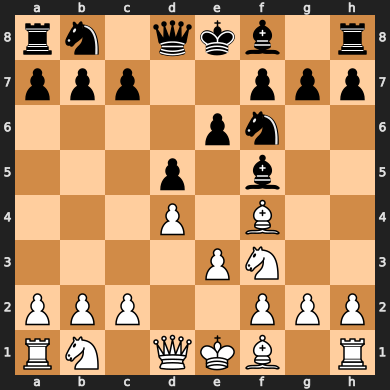

In [164]:
chess.Board(random_fen)

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 91 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fen                    1103 non-null   object 
 1   next_move              1103 non-null   object 
 2   games_count            1103 non-null   int64  
 3   global_avg_elo         1103 non-null   float64
 4   global_winrate         1103 non-null   float64
 5   engine_move            1103 non-null   object 
 6   delta                  1103 non-null   float64
 7   fragility_score        1103 non-null   float64
 8   variance               1103 non-null   float64
 9   score                  1103 non-null   float64
 10  group_count_500        570 non-null    float64
 11  winrate_500            570 non-null    float64
 12  score_500              1103 non-null   float64
 13  recommended_move_500   1103 non-null   object 
 14  historical_best_500    762 non-null    object 
 15  is_b

In [166]:
df["f_cross_d"] = df["fragility_score"] * df["delta"]
df["f_cross_v"] = df["fragility_score"] * df["variance"]
df["d_cross_v"] = df["delta"] * df["variance"]

df_reg = df[pd.notna(df["is_best_1500"])]
selected_features = ["fragility_score", "delta", "variance", "f_cross_d", "f_cross_v", "d_cross_v"]
X = df_reg[selected_features]
y = df_reg["is_best_1500"].fillna(False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [167]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {acc_log:.3f}")

Logistic Regression Accuracy: 0.556


In [168]:
print("Logistic Regression Coefficients:")
for feature, coef in zip(selected_features, log_model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

Logistic Regression Coefficients:
fragility_score: 0.203
delta: 0.529
variance: 0.241
f_cross_d: -0.149
f_cross_v: -0.042
d_cross_v: -0.122


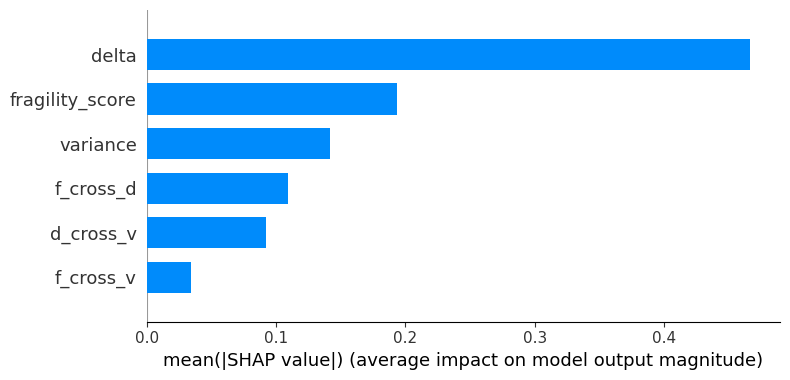

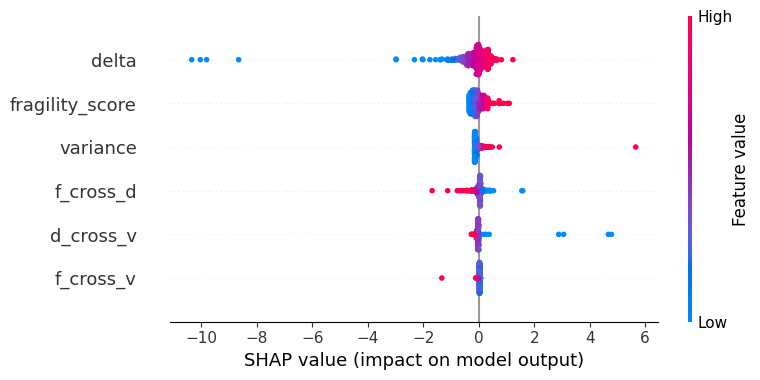

In [169]:
explainer_log = shap.Explainer(log_model, X_train)
shap_values_log = explainer_log(X_test)
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, show=True)

In [170]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.3f}")

XGBoost Accuracy: 0.575


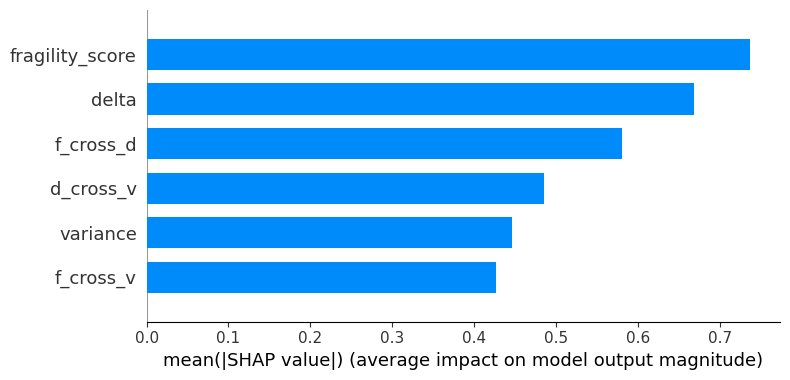

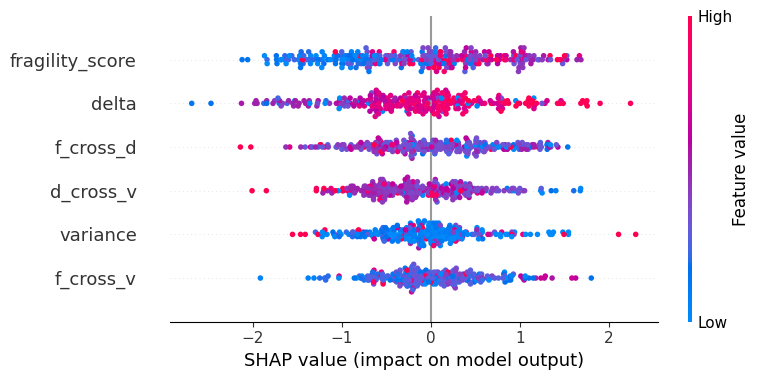

In [171]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)
shap.summary_plot(shap_values_xgb, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_xgb, features=X_test, feature_names=selected_features, show=True)